## Prepare Dataset and Image Preprocessing

The original dataset was obtained from the [APTOS 2019 Blindness Detection competition](https://www.kaggle.com/c/aptos2019-blindness-detection/).


### 1. Load necessary libraries and dataset

The original dataset is not provided in the repository.

In [1]:
import numpy as np
import pandas as pd
import cv2
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

The dataset contains retina images taken using fundus photography each with a label indicating the severity of diabetic retinopathy.
Each image is labeled based on five types of fundus images: **no DR, mild, moderate, severe,** and **proliferate DR** with integer labels 0-4.

Due to the lack of classification labels for the test dataset, only the training set of the original competition was used in this study to create datasets for training and validation.

Each label group of images was splitted separately to ensure a balanced distribution of training and validation samples across label groups.

In [2]:
# input directory
data_dir = "aptos2019-blindness-detection"

# output directory
output_dir = "preprocessed_images"

df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

In [3]:
train, test = train_test_split(df[df['level']==0], test_size = 0.2)
for i in range(1, 5):
    tr, te = train_test_split(df[df['level']==i], test_size = 0.2)
    train = pd.concat([train, tr])
    test = pd.concat([test, te])
print("The number of images in training set is ", train.shape[0])
print("The number of images in test set is ", test.shape[0])

The number of images in training set is  2929
The number of images in test set is  733


### 2. Image Preprocessing
Due to the diverse sources of images and inconsistent lighting conditions as well as equipment conditions under which the images were taken,
images in this dataset varied significantly in their resolution, size and quality.

Thus, these images were preprocessed in following ways:
a. black background around the retina was removed as much as possible;
b. the left retina part was then resized and cropped around the center of retina to yield a circular-shaped image;
c. certain amount of Gaussian Blur was added to images to highlight the critical details in the image (shown below)

![Retina changes result from DR (https://www.eyeops.com/contents/our-services/eye-diseases/diabetic-retinopathy)](report_images/DR_details.jpeg)

**Some functions for preprocessing**

In [4]:
def crop_image_from_gray(img, tol=7):
    """
    Crop out black borders around retina. Uesd within circle_crop function
    credit to: https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img>tol
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if check_shape == 0:
        return img
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        img = np.stack([img1,img2,img3],axis=-1)
    return img

def circle_crop(img):
    """
    Create circular crop around image centre
    credit to: https://www.kaggle.com/taindow/pre-processing-train-and-test-images
    """
    img = crop_image_from_gray(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

**Transform dataset images**

In [5]:
# transform training set
cnt_train = 0
processed_train = train.copy()
for idx, row in train.iterrows():
    img_name = row['image']+".png"
    classname = row['level']

    # original image path
    img_input = os.path.join(data_dir, 'train_images', img_name)
    # save path of processed image
    save_img = os.path.join(output_dir, "train", str(classname), img_name)

    # bypass missing images
    if not os.path.exists(img_input):
        processed_train.drop(index=idx, inplace=True)
        continue
    cnt_train += 1
    if os.path.exists(save_img):
        continue

    cimg = cv2.imread(img_input, cv2.IMREAD_COLOR)

    cirimg = circle_crop(cimg)
    cirimg = cv2.resize(cirimg, (224,224))
    final_img=cv2.addWeighted(cirimg,4, cv2.GaussianBlur(cirimg, (0,0) , 10) ,-4 ,128)

    # store processed images in directories of its label
    cv2.imwrite(save_img, final_img)

processed_train.to_csv(os.path.join(output_dir, "train.csv"))
print(f"Training set: {cnt_train} images processed")

Training set: 2920 images processed


In [6]:
# transform test set
cnt_test = 0
processed_test = test.copy()
for idx, row in test.iterrows():
    img_name = row['image']+".png"
    classname = row['level']

    # original image path
    img_input = os.path.join(data_dir, 'train_images', img_name)
    # save path of processed image
    save_img = os.path.join(output_dir, "test", str(classname), img_name)

    # bypass missing images
    if not os.path.exists(img_input):
        processed_test.drop(index=idx, inplace=True)
        continue
    cnt_test += 1
    if os.path.exists(save_img):
        continue

    cimg = cv2.imread(img_input, cv2.IMREAD_COLOR)

    cirimg = circle_crop(cimg)
    cirimg = cv2.resize(cirimg, (224,224))
    final_img = cv2.addWeighted(cirimg,4, cv2.GaussianBlur(cirimg, (0,0) , 10) ,-4 ,128)

    # store processed images in directories of its label
    cv2.imwrite(save_img, final_img)

processed_test.to_csv(os.path.join(output_dir, "test.csv"))
print(f"Test set: {cnt_test} images processed")

Test set: 728 images processed


**Results**

Here we show several examples of the original images as well as ones after preprocessing.

In [7]:
# pick random samples from the training set
samples = processed_train.sample(5).reset_index()

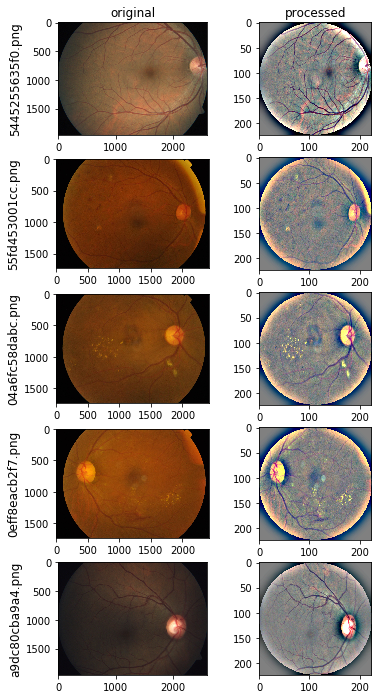

In [8]:
fig, axe = plt.subplots(5,2,figsize=(6,12))
rows = []

for idx, row in samples.iterrows():
    img_name = row['image']+'.png'
    rows.append(img_name)
    classname = row['level']
    ori_img = cv2.imread(os.path.join(data_dir, 'train_images', img_name))
    post_img = cv2.imread(os.path.join(output_dir, "train", str(classname), img_name))

    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)

    axe[idx, 0].imshow(ori_img)
    axe[idx, 1].imshow(post_img)

cols = ['original', 'processed']
for ax, col in zip(axe[0], cols):
    ax.set_title(col, fontsize=12)
for ax, row in zip(axe[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12)
plt.show()

The created dataset was then used to train various CNN models and predict the labels.
